# LSTM Multivariate Model

In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from sklearn.impute import KNNImputer

In [26]:
X_train = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train_scaled.csv')
X_cv = pd.read_csv('X_val_scaled.csv')
y_cv = pd.read_csv('y_val_scaled.csv')
X_train_cv = pd.read_csv('X_train_val_scaled.csv')
y_train_cv = pd.read_csv('y_train_val_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')
y_test = pd.read_csv('y_test_scaled.csv')

val =  pd.read_csv('val.csv')
y_val = pd.read_csv('y_val.csv')
test =  pd.read_csv('test.csv')
test_y = pd.read_csv('y_test.csv')

 ## Defining LSTM Model & MAPE Functions

In [3]:
def run(neurons, batchSize, numEpochs, X, Y, pred_set, orig, col_mean, col_std):
    #Reshaping
    trainX =np.array(X)
    X = trainX.reshape(X.shape[0], 1, X.shape[1])
    
    testX =np.array(pred_set)
    pred_set = testX.reshape(pred_set.shape[0], 1, pred_set.shape[1])
    
    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(neurons, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss="mean_squared_error", optimizer="adam")
    plot_model(lstm, show_shapes=True, show_layer_names=True)

    ##################################################
    
    # Fitting the RNN to the Training set
    history = lstm.fit(X, Y, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False)
    predicted_Price = lstm.predict(pred_set)
    
    predicted_price_df = pd.DataFrame(predicted_Price, columns=['Predicted Price'])
    
    # Scale Back Result
    est = predicted_price_df['Predicted Price'] * col_std + col_mean

    rmse = sqrt(mean_squared_error(orig, est))
    mape = get_mape(orig, est)
    
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [4]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Param

In [5]:
# vary training batches
param_label = 'epochs'
param_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# param_list = [10]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32
default_neurons = 32

for param in param_list:
    rmse, mape = run(default_neurons, default_batch_size, param, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50


2022-04-28 18:44:10.185105: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 1ms/step - loss: 0.1516
Epoch 2/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0804
Epoch 3/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 4/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 5/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 6/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 7/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0172
Epoch 8/50
14/14 [==============================] - 0s 989us/step - loss: 0.0125
Epoch 9/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 10/50
14/14 [==============================] - 0s 984us/step - loss: 0.0082
Epoch 11/50
14/14 [==============================] - 0s 988us/step - loss: 0.0075
Epoch 12/50
14/14 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 13/50
14/14 [==============================] - 0

,epochs,rmse,mape
0,50,2634.763089,18.154072
1,100,2619.308106,18.155156
2,150,2624.809061,18.137591
3,200,2715.191364,18.266931
4,250,2633.363870,18.182317
5,300,2665.858271,18.221726
6,350,2635.348803,18.202190
7,400,2610.347278,18.178694
8,450,2647.657953,18.229230
9,500,2649.644100,18.200395


In [6]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 2610.347
optimum params = 400


In [7]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 18.138%
optimum params = 150


## Tuning Batch Size Parameter

In [8]:
# vary training batches
param_label = 'batch_size'
param_list = [32, 64, 128, 256]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_neurons = 32

for param in param_list:
    rmse, mape = run(default_neurons, param, epoch_opt, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/400
14/14 [==============================] - 1s 1ms/step - loss: 0.1434
Epoch 2/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 3/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0356
Epoch 4/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 5/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0334
Epoch 6/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 7/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 8/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 9/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 10/400
14/14 [==============================] - 0s 988us/step - loss: 0.0082
Epoch 11/400
14/14 [===============

,batch_size,rmse,mape
0,32,2627.270368,18.161105
1,64,2628.467788,18.202084
2,128,2644.610635,18.201512
3,256,2639.729802,18.202586


In [9]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 2627.270
optimum params = 32


In [10]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 18.161%
optimum params = 32


In [11]:
# vary neurons
param_label = 'neurons'
param_list = [10, 20, 30, 40, 50]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32

for param in param_list:
    rmse, mape = run(param, default_batch_size, epoch_opt, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/400
14/14 [==============================] - 1s 1ms/step - loss: 0.2118
Epoch 2/400
14/14 [==============================] - 0s 1ms/step - loss: 0.1153
Epoch 3/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0614
Epoch 4/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 5/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 6/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 7/400
14/14 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 8/400
14/14 [==============================] - 0s 999us/step - loss: 0.0145
Epoch 9/400
14/14 [==============================] - 0s 970us/step - loss: 0.0122
Epoch 10/400
14/14 [==============================] - 0s 944us/step - loss: 0.0109
Epoch 11/400
14/14 [===========

,neurons,rmse,mape
0,10,2651.356291,18.189619
1,20,2640.487464,18.189797
2,30,2636.345600,18.203994
3,40,2629.814847,18.205360
4,50,2619.347848,18.185316


In [12]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
neurons_opt = temp['neurons'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(neurons_opt))

min RMSE = 2619.348
optimum params = 50


In [13]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['neurons'].values[0]))

min MAPE = 18.185%
optimum params = 50


## Model with Optimal Parameters

In [30]:
# Process the data for LSTM
testX =np.array(X_test)
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
traincvX =np.array(X_train_cv)
X_train_cv = traincvX.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])

In [31]:
# Building the LSTM Model

start = time.time()


lstm = Sequential()
lstm.add(LSTM(neurons_opt, input_shape=(1, traincvX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

# Model Training
history = lstm.fit(X_train_cv, y_train_cv, epochs = epoch_opt, batch_size = batch_size_opt, verbose=1, shuffle=False)
# LSTM Prediction
y_pred = lstm.predict(X_test)

predicted_price_df = pd.DataFrame(y_pred, columns=['Predicted Price'])
    
# Scale Back Result
est = predicted_price_df['Predicted Price'] * test['Close_std'] + test['Close_mean']

end = time.time()
time_elapsed = end - start
print("Time Elapsed = ", time_elapsed)


rmse = sqrt(mean_squared_error(test_y, est))
mape = get_mape(test_y, est)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/400
19/19 [==============================] - 1s 2ms/step - loss: 0.0665
Epoch 2/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0698
Epoch 3/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 4/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 5/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 6/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 7/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 8/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 9/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 10/400
19/19 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 11/400
19/19 [=================

In [16]:
# Calculating RMSE & MAPE for each round of shifting for 5 days
for i in range(5):
    est = est[i+1:]
    test_y = test_y[:-(i+1)]
    
    rmse = sqrt(mean_squared_error(test_y, est))
    mape = get_mape(test_y, est)

    # Calculate RMSE
    print("RMSE on test set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on test set = %0.3f%%" % mape)
    print("\n")

RMSE on test set = 2297.880
MAPE on test set = 22.231%


RMSE on test set = 1707.588
MAPE on test set = 22.267%


RMSE on test set = 2453.100
MAPE on test set = 22.107%


RMSE on test set = 3681.792
MAPE on test set = 21.629%


RMSE on test set = 4579.284
MAPE on test set = 20.921%




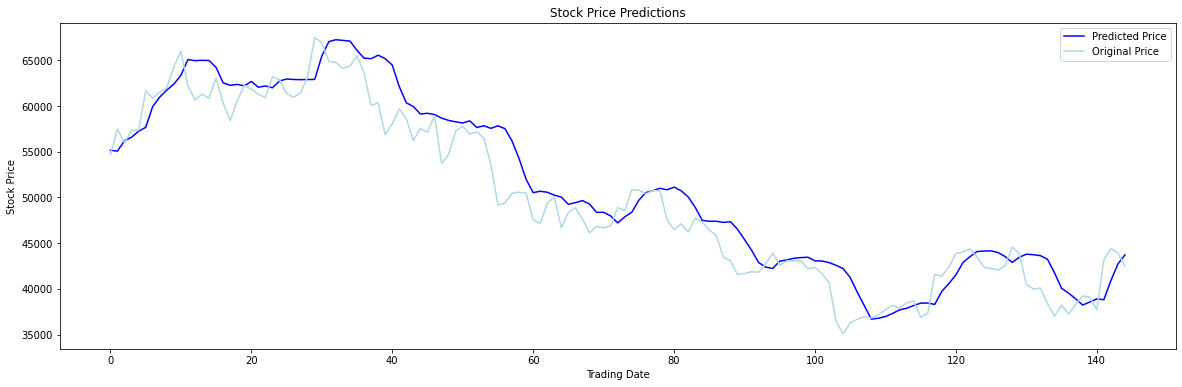

In [28]:
plt.plot(est, color = 'blue', label = 'Predicted Price')
plt.plot(test_y, color = 'lightblue', label = 'Original Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Prediction

In [18]:
predict_feature = pd.read_csv('predict_feature.csv')

In [19]:
# Process the data for LSTM
testX =np.array(predict_feature)
predict_feature = testX.reshape(predict_feature.shape[0], 1, predict_feature.shape[1])
predict_feature

array([[[0.53494289, 0.62718398, 0.63747015, 0.30237581, 0.19623401,
         0.25062473, 0.46436467, 0.46944603, 0.28855979, 0.54238339,
         0.61126824, 0.65190672, 0.30237581, 0.20485842, 0.23595433,
         0.42488987, 0.45316945, 0.26122203, 0.53940674, 0.59048656,
         0.7266844 , 0.28077754, 0.23291649, 0.22320121, 0.39781412,
         0.43610698, 0.23564326, 0.52835439, 0.5703024 , 0.65288979,
         0.30237581, 0.2276556 , 0.21294701, 0.36698343, 0.40669111,
         0.21667954, 0.53695683, 0.57208171, 0.63260644, 0.2699784 ,
         0.2392123 , 0.2168031 , 0.39695217, 0.43021982, 0.26408256]]])

In [20]:
predicted_price = lstm.predict(predict_feature)

predicted_price_df = pd.DataFrame(predicted_price, columns=['Predicted Price'])
    
# Scale Back Result
close_mean = test['Close_mean'][-5:].mean()
close_std = test['Close_std'][-5:].mean()
est = predicted_price_df['Predicted Price'] * close_std + close_mean

In [21]:
est

0    40919.675781
Name: Predicted Price, dtype: float32

Reality: Bitcoin currency had a close price of USD 39,137.61 on 4 Mar 2022.

Prediced: Our model predicted the currency to have a close price of USD 40919.675781 on 4 Mar 2022.